In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

X-ray images of chest of different persons are provided. Our task is to predict if the given person has pneumonia. 
The model developed is a CNN model. The details of the model are given below.

In [16]:
# Importing nessecary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


In [2]:
train_file= '../input/chest-xray-pneumonia/chest_xray/train/'
test_file = '../input/chest-xray-pneumonia/chest_xray/test/'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_dataset = train_datagen.flow_from_directory(train_file,
                                                      target_size=(150,150),
                                                  batch_size=32,
                                                  color_mode='grayscale',
                                                    class_mode ='categorical')

test_datagen = ImageDataGenerator(rescale=1./255,)
test_dataset = test_datagen.flow_from_directory(test_file,
                                                      target_size=(150,150),
                                                  batch_size=1,
                                                  color_mode='grayscale',
                                                    class_mode ='categorical',
                                                shuffle=False)
#Batch size for test data is one, as we pass one image at a time unlike training dataset

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


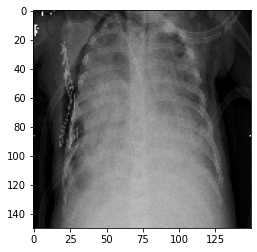

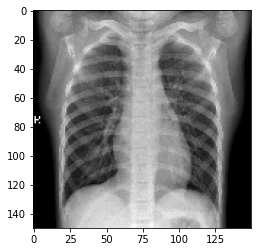

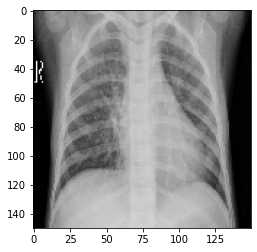

In [4]:
#Visualizing the data
x_batch, y_batch = next(train_dataset)
x_batch = np.squeeze(x_batch)

for i in range (0,3):
    image = x_batch[i]
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

In [5]:
model = Sequential()

model.add(Conv2D(filters= 64, padding='same', kernel_size=(11,11), input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(75, (7,7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3,3), strides=(3,3)))

model.add(Conv2D(100, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((5,5), (5,5)))

model.add(Flatten())
model.add(Dense(75, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(25, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(2,activation='softmax'))


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      7808      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 75)        235275    
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 75)        300       
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 75)       

In [7]:
#Compiling the model
model.compile (loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
# Fitting the model
model.fit(train_dataset, epochs=3)

Epoch 1/4
163/163 [==============================] - 851s 5s/step - loss: 0.2612 - accuracy: 0.9126
Epoch 2/4
163/163 [==============================] - 856s 5s/step - loss: 0.1106 - accuracy: 0.9549
Epoch 3/4
163/163 [==============================] - 858s 5s/step - loss: 0.0765 - accuracy: 0.9674
Epoch 4/4
163/163 [==============================] - 854s 5s/step - loss: 0.0803 - accuracy: 0.9693


In [10]:
model.evaluate_generator(test_dataset, verbose=1)

624/624 [==============================] - 33s 53ms/step


[0.6294796466827393, 0.8269230723381042]

In [11]:
cost_df = pd.DataFrame(model.history.history)
loss = cost_df['loss']
accuracy = cost_df['accuracy']

LOSS:
0    0.261247
1    0.110563
2    0.076475
3    0.080289
Name: loss, dtype: float64

ACCURACY:
0    0.912577
1    0.954946
2    0.967408
3    0.969325
Name: accuracy, dtype: float64


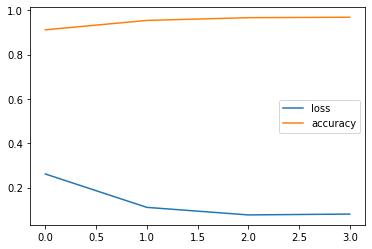

In [12]:
cost_df.plot()
print("LOSS:\n{}\n".format(loss))
print("ACCURACY:\n{}".format(accuracy))

 Train accuracy is 97% and test accuracy is 82.6%. 

In [15]:
Y_pred = model.predict_generator(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_dataset.classes, y_pred))

Confusion Matrix
[[159  75]
 [ 33 357]]


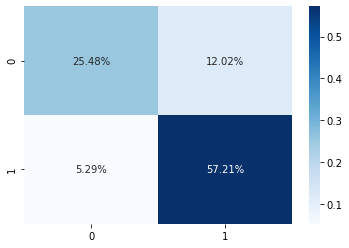

In [17]:
cf_matrix = confusion_matrix(test_dataset.classes, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [19]:
precision = cf_matrix[0][0]/(cf_matrix[0][0]+cf_matrix[0][1])
recall = cf_matrix[0][0]/(cf_matrix[0][0]+cf_matrix[1][0])
print('Precision = {}\n'.format(precision))
print('Recall = {}'.format(recall))

Precision = 0.6794871794871795

Recall = 0.828125


Thus we have achieved a good recall of 82.8%